# Variational AutoEncoder for MNIST (with GPU implementation)

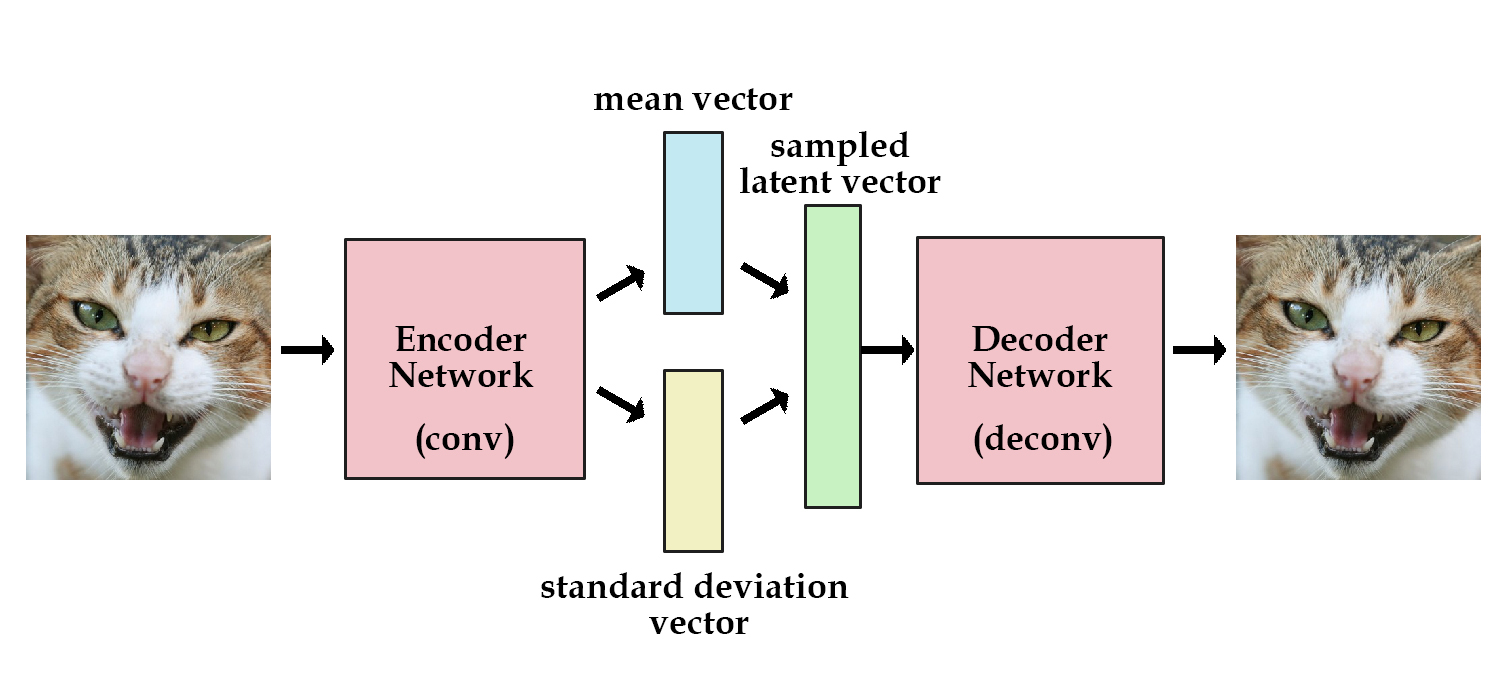
Schematic of a VAE

## Idea behind VAE:

* Simple autoencoders are great. Encoder encodes input image into a latent vector that a decoder can use to generate the image.

* Hoewever, we are looking for generative models, where we can generate new images from the latent representation.

* The idea is to ensure that a latent vector follows a unit Gaussian distribution, and then use the Gaussian distribution to generate new images.

* In practice, there's a tradeoff between how accurate our network can be and how close its latent variables can match the unit gaussian distribution.

* We let the network decide this itself. For our loss term, we sum up two separate losses: the generative loss, which is a mean squared error that measures how accurately the network reconstructed the images, and a latent loss, which is the KL divergence that measures how closely the latent variables match a unit gaussian.

generation_loss = mean(square(generated_image - real_image))  
latent_loss = KL-Divergence(latent_variable, unit_gaussian)  
loss = generation_loss + latent_loss

* In order to optimize the KL divergence, we need to apply a simple reparameterization trick: instead of the encoder generating a vector of real values, it will generate a vector of means and a vector of standard deviations. This lets us calculate KL divergence.

* When we're calculating loss for the decoder network, we can just sample from the standard deviations and add the mean, and use that as our latent vector.

* In addition to allowing us to generate random latent variables, this constraint also improves the generalization of our network.

## Let's dive into Mathematics of VAE

* **Encoder**'s input is a datapoint $x$, its output is a hidden representation $z$, and it has weights and biases $\theta$.


* Encoder outputs parameters to $q_\theta (z \vert x)$, which is a Gaussian probability density.


* We can sample from this distribution to get noisy values of the representations $z$.


* **Decoder**'s input is the representation $z$, it outputs the parameters to the probability distribution of the data, and has weights and biases $\phi$.


* The decoder is denoted by $p_\phi(x\vert z)$.


* *Loss function* of the variational autoencoder is the negative log-likelihood with a regularizer.

$$l_i(\theta,\phi) = -\mathbb{E}_{z\sim q_\theta(z\vert x_i)}[\log p_\phi(x_i\vert z)] + KL(q_\theta(z\vert x_i)||p(z))$$


* In the variational autoencoder, $p~N(0,\mathbb{1})$ is specified as a standard Normal distribution with mean zero and variance one.


#### Reparametrization trick: (How to take derivatives with respect to the parameters of a stochastic variable?)

* If we are given zz that is drawn from a distribution $q_\theta (z \vert x)$, and we want to take derivatives of a function of $z$ with respect to $\theta$, how do we do that?


* We want our samples to deterministically depend on the parameters of the distribution.


* For example, in a normally-distributed variable with mean $\mu$ and standard devation $\sigma$, we can sample from it like this:

$$z = \mu + \sigma\odot\epsilon,$$
where $\epsilon\sim N(0,1)$.


* We have defined a function that depends on on the parameters deterministically. We can thus take derivatives of functions involving $z$, $f(z)$ with respect to the parameters of its distribution $\mu$ and $\sigma$.

### Import necessary libraries

In [1]:
import os #will be used for creating directories, etc.

import torch
import torchvision.datasets as dsets             #for downloading dataset
import torchvision.transforms as transforms      #for transforming dataset into tensors

from torch import nn
import torchvision

from torch.autograd import Variable

from torch.nn import functional as F

from time import time

### Prepare MNIST dataset

In [2]:
#download MNIST dataset
dataset = dsets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

### Utility functions

In [3]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

### Training parameters

In [4]:
batch_size = 100
num_epochs = 50

# shuffle and prepare dataset with minibatches
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

### Create Autoencoder NN

In [5]:
intermediate_size = 100
hidden_size       = 30

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        
        # Define encoder
        self.fc_enc = nn.Linear(784, intermediate_size)
        
        # Latent representation
        self.fc_mu  = nn.Linear(intermediate_size, hidden_size)
        self.fc_sig = nn.Linear(intermediate_size, hidden_size)
        
        # Define decoder
        self.fc_dec1 = nn.Linear(hidden_size, intermediate_size)
        self.fc_dec2 = nn.Linear(intermediate_size, 784)
        
        self.relu    = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    
    def encode(self, x):
        out = self.relu(self.fc_enc(x))    
        return self.fc_mu(out), self.fc_sig(out)
    
    
    def reparameterize(self, mu, logvar):
        if self.training:   # there are 2 modes: training and evaluation
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    
    def decode(self, z):
        out = self.relu(self.fc_dec1(z))
        out = self.sigmoid(self.fc_dec2(out))
        return out
    
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
# Create Autoencoder model
vae = VariationalAutoencoder()

if torch.cuda.is_available():
    vae.cuda()

### Optimizer

In [7]:
optimizer = torch.optim.RMSprop(vae.parameters(), lr=0.001)

### Loss function

In [8]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

### Let's train!!

In [9]:
# We want to go through all the examples in each epoch, so number of iterations per epoch
iter_per_epoch = len(data_loader)
data_iter      = iter(data_loader) # data_iter is an iterator object

#### Now we want to view and save results on a fixed batch to visualize Autoencoder's performance

In [10]:
# save fixed inputs for debugging
fixed_x, _ = next(data_iter)        #points to the first batch
torchvision.utils.save_image(Variable(fixed_x).data.cpu(), './data/real_images.png')
fixed_x = to_var(fixed_x.view(fixed_x.size(0), -1))

### Begin training

In [11]:
for epoch in range(num_epochs):
    t0 = time()
    vae.train()      # sets self.training to True
    for i, (images, _) in enumerate(data_loader):
        
        # flatten the image
        images                  = to_var(images.view(images.size(0), -1))
        recon_batch, mu, logvar = vae(images)
        loss                    = loss_function(recon_batch, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()         # calculate gradients
        optimizer.step()        # update parameters
        
        # display training process after every 100 iterations
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f Time: %.2fs' 
                %(epoch+1, num_epochs, i+1, len(dataset)//batch_size, loss.data[0], time()-t0))
            
    # save the reconstructed images
    reconst_images, _, _ = vae(fixed_x)
    reconst_images = reconst_images.view(reconst_images.size(0), 1, 28, 28)
    torchvision.utils.save_image(reconst_images.data.cpu(), './data/reconst_images_%d.png' % (epoch+1))
    
    # generate new samples
    with torch.no_grad():
        if torch.cuda.is_available():
            sample = torch.randn(64, hidden_size).to("cuda")
        else:
            sample = torch.randn(64, hidden_size).to("cpu")
            
        sample = vae.decode(sample).cpu()
        torchvision.utils.save_image(sample.view(64, 1, 28, 28), './results/sample_' + str(epoch) + '.png')
    

C:\Users\mayan\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\mayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/50], Iter [100/600] Loss: 18843.7383 Time: 1.93s
Epoch [1/50], Iter [200/600] Loss: 17328.2598 Time: 3.54s
Epoch [1/50], Iter [300/600] Loss: 15977.0879 Time: 5.11s
Epoch [1/50], Iter [400/600] Loss: 15958.7930 Time: 6.66s
Epoch [1/50], Iter [500/600] Loss: 15622.3545 Time: 8.22s
Epoch [1/50], Iter [600/600] Loss: 14783.3789 Time: 9.79s
Epoch [2/50], Iter [100/600] Loss: 14576.5244 Time: 1.56s
Epoch [2/50], Iter [200/600] Loss: 14196.1064 Time: 3.17s
Epoch [2/50], Iter [300/600] Loss: 13982.8086 Time: 4.83s
Epoch [2/50], Iter [400/600] Loss: 13412.2207 Time: 6.49s
Epoch [2/50], Iter [500/600] Loss: 13431.0225 Time: 8.29s
Epoch [2/50], Iter [600/600] Loss: 13188.0801 Time: 9.92s
Epoch [3/50], Iter [100/600] Loss: 13202.7334 Time: 1.70s
Epoch [3/50], Iter [200/600] Loss: 13075.4414 Time: 3.54s
Epoch [3/50], Iter [300/600] Loss: 12653.1768 Time: 5.24s
Epoch [3/50], Iter [400/600] Loss: 12911.8701 Time: 6.89s
Epoch [3/50], Iter [500/600] Loss: 12303.5654 Time: 8.58s
Epoch [3/50], 

Epoch [47/50], Iter [200/600] Loss: 10765.4492 Time: 3.38s
Epoch [47/50], Iter [300/600] Loss: 11276.9023 Time: 5.24s
Epoch [47/50], Iter [400/600] Loss: 10860.0781 Time: 6.98s
Epoch [47/50], Iter [500/600] Loss: 11038.3945 Time: 8.73s
Epoch [47/50], Iter [600/600] Loss: 11033.4785 Time: 10.46s
Epoch [48/50], Iter [100/600] Loss: 10874.1641 Time: 1.71s
Epoch [48/50], Iter [200/600] Loss: 10378.1221 Time: 3.40s
Epoch [48/50], Iter [300/600] Loss: 10884.1484 Time: 5.06s
Epoch [48/50], Iter [400/600] Loss: 10891.1729 Time: 6.75s
Epoch [48/50], Iter [500/600] Loss: 11106.7686 Time: 8.47s
Epoch [48/50], Iter [600/600] Loss: 11027.3711 Time: 10.19s
Epoch [49/50], Iter [100/600] Loss: 11112.6523 Time: 1.75s
Epoch [49/50], Iter [200/600] Loss: 11421.0684 Time: 3.57s
Epoch [49/50], Iter [300/600] Loss: 10425.9766 Time: 5.46s
Epoch [49/50], Iter [400/600] Loss: 11390.8926 Time: 7.15s
Epoch [49/50], Iter [500/600] Loss: 11013.9082 Time: 8.92s
Epoch [49/50], Iter [600/600] Loss: 10856.5234 Time: 1